### Project Overview
- The goal of this project is to finde out og the Capital Markets have predicictive insitights on the Aaa Voporate bond yield. 
- You are also assiged to use a Recurrent Neural Netwok to forcast the Aaa bonld yield one day in to the futore. How accurate is your model for both of these predictions? Wich approach sems more resonable
- Time frame is a 10 year data set beginning 6-22-2010

In [2]:
import pandas as pd
import numpy as np
from pandas_datareader import data as web
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
aaa = pd.read_csv("resources/MoodyAAAYield.csv", parse_dates = True,  index_col="DATE")

In [7]:
aaa.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2610 entries, 2010-06-22 to 2020-06-22
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DAAA    2610 non-null   object
dtypes: object(1)
memory usage: 40.8+ KB


### Checking for missing data
- There is no missing Data but the data is not numeric and will need to be converted
- We also have "." as string values that need to be replaced

In [9]:
aaa.isnull().sum()

DAAA    0
dtype: int64

### Replacing ". " with nan

In [13]:
aaa.replace(["."], np.nan, inplace=True)

In [17]:
aaa.isnull().sum()

DAAA    106
dtype: int64

### Converting values to numeric values

In [18]:
aaa["DAAA"] = pd.to_numeric(aaa["DAAA"])

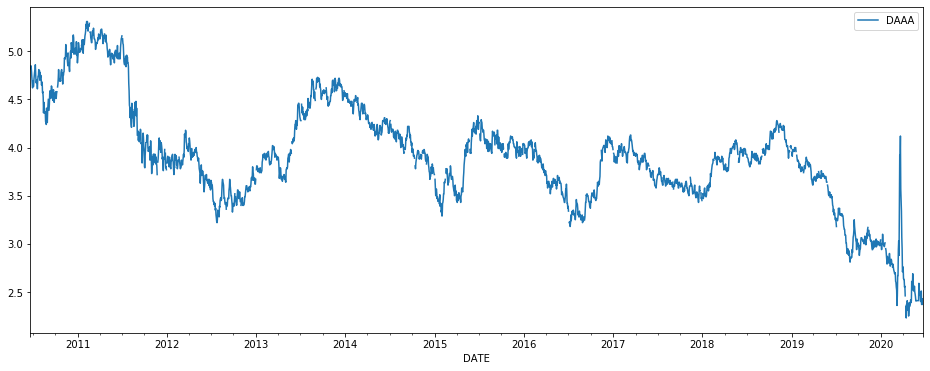

In [21]:
aaa.plot(figsize= (16,6))

### Gathering Capital Markets Data

In [22]:
tickers = ["^GSPC", "^DJI", "^IXIC", "^RUT"]

In [23]:
capital_data = pd.DataFrame()

In [24]:
for t in tickers:
    capital_data[t] = web.DataReader(t, data_source="yahoo", start = "2010-6-22", end = "2020-06-22")["Adj Close"]

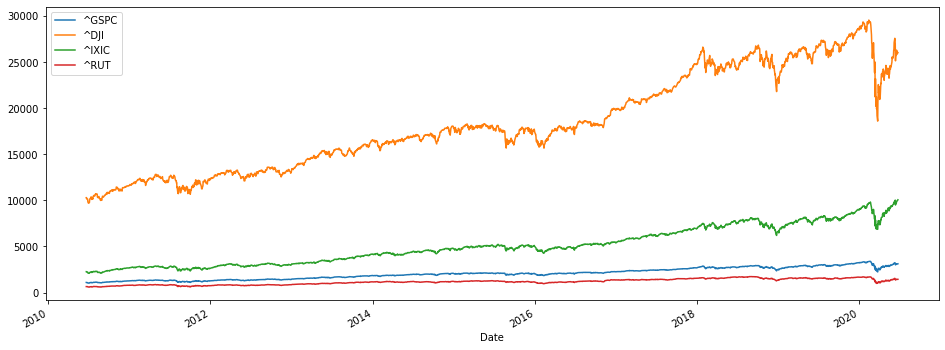

In [28]:
capital_data.plot(figsize =(16,6))

####  Combining the Data
 - Putting the Aaa data with the capital markets data

In [29]:
working_data = pd.concat([capital_data, aaa], axis=1)

In [76]:
working_data.dropna(inplace=True)

### Coorelating the data
- Aaa bond yield is inversely coorelate to the capital markets

In [77]:
working_data.corr()

,^GSPC,^DJI,^IXIC,^RUT,DAAA
^GSPC,1.000000,0.992663,0.990889,0.966972,-0.619090
^DJI,0.992663,1.000000,0.985681,0.965364,-0.595754
^IXIC,0.990889,0.985681,1.000000,0.937726,-0.635076
^RUT,0.966972,0.965364,0.937726,1.000000,-0.480841
DAAA,-0.619090,-0.595754,-0.635076,-0.480841,1.000000


In [78]:
working_data.isna().sum()

^GSPC    0
^DJI     0
^IXIC    0
^RUT     0
DAAA     0
dtype: int64

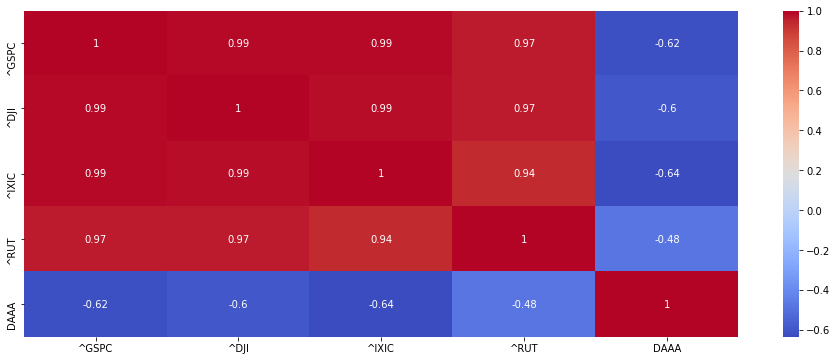

In [80]:
plt.figure(figsize=(16,6))
sns.heatmap(working_data.corr(), annot=True, cmap="coolwarm")

## Preparing Data
- Target will be the value of the Aaa coporate bond yield

In [81]:
X = working_data.drop("DAAA", axis=1).values
y = working_data["DAAA"].values

## Training Testing and Splitting

In [82]:
from sklearn.model_selection import train_test_split

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=101)

In [84]:
X_train.shape

(1500, 4)

In [85]:
X_test.shape

(1001, 4)

In [86]:
y_test.shape

(1001,)

In [87]:
y_train.shape

(1500,)

## Scaling to a normal Distrubution

In [88]:
from sklearn.preprocessing import MinMaxScaler

In [89]:
scalar = MinMaxScaler()

In [90]:
X_train = scalar.fit_transform(X_train)

In [91]:
X_test = scalar.transform(X_test)

## Early Stopping
 - Early Stopping will prevent us from overfitting the data to the model

In [92]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

In [93]:
stop = EarlyStopping(monitor="val_loss", mode="min", patience=30)

### Tensor Board
- Will create a board to get a visual of the layers of the network and each epoch stage

In [94]:
log_dir = "resources/logs/fit"
board = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=0,
    embeddings_metadata=None,
)

### Creating Model
- Will use Keras Sequential Model

In [95]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [154]:
model = Sequential()
model.add(Dense(units = 30, activation = "relu"))
model.add(Dense(units = 30, activation = "relu"))
model.add(Dense(units = 20, activation = "relu"))
model.add(Dense(units = 20, activation = "relu"))
model.add(Dense(units = 10, activation = "relu"))
model.add(Dense(units = 1))
model.compile(loss = "mse", optimizer = "adam")

### Fitting Model

In [155]:
model.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=350, callbacks=[stop, board])

Train on 1500 samples, validate on 1001 samples
Epoch 1/350
1500/1500 [==============================] - 2s 2ms/sample - loss: 12.8086 - val_loss: 8.1039
Epoch 2/350
1500/1500 [==============================] - 0s 204us/sample - loss: 2.9317 - val_loss: 1.5863
Epoch 3/350
1500/1500 [==============================] - 0s 206us/sample - loss: 0.9305 - val_loss: 0.5419
Epoch 4/350
1500/1500 [==============================] - 0s 210us/sample - loss: 0.2876 - val_loss: 0.2044
Epoch 5/350
1500/1500 [==============================] - 0s 202us/sample - loss: 0.1796 - val_loss: 0.1893
Epoch 6/350
1500/1500 [==============================] - 0s 207us/sample - loss: 0.1638 - val_loss: 0.2103
Epoch 7/350
1500/1500 [==============================] - 0s 206us/sample - loss: 0.1578 - val_loss: 0.1667
Epoch 8/350
1500/1500 [==============================] - 0s 207us/sample - loss: 0.1499 - val_loss: 0.1640
Epoch 9/350
1500/1500 [==============================] - 0s 205us/sample - loss: 0.1460 - val_los

1500/1500 [==============================] - 0s 205us/sample - loss: 0.0561 - val_loss: 0.0552
Epoch 77/350
1500/1500 [==============================] - 0s 204us/sample - loss: 0.0544 - val_loss: 0.0554
Epoch 78/350
1500/1500 [==============================] - 0s 200us/sample - loss: 0.0554 - val_loss: 0.0610
Epoch 79/350
1500/1500 [==============================] - 0s 202us/sample - loss: 0.0581 - val_loss: 0.0589
Epoch 80/350
1500/1500 [==============================] - 0s 206us/sample - loss: 0.0579 - val_loss: 0.0544
Epoch 81/350
1500/1500 [==============================] - 0s 201us/sample - loss: 0.0545 - val_loss: 0.0531
Epoch 82/350
1500/1500 [==============================] - 0s 205us/sample - loss: 0.0549 - val_loss: 0.0541
Epoch 83/350
1500/1500 [==============================] - 0s 207us/sample - loss: 0.0550 - val_loss: 0.0538
Epoch 84/350
1500/1500 [==============================] - 0s 201us/sample - loss: 0.0552 - val_loss: 0.0577
Epoch 85/350
1500/1500 [=================

1500/1500 [==============================] - 0s 200us/sample - loss: 0.0436 - val_loss: 0.0480
Epoch 152/350
1500/1500 [==============================] - 0s 202us/sample - loss: 0.0452 - val_loss: 0.0514
Epoch 153/350
1500/1500 [==============================] - 0s 199us/sample - loss: 0.0469 - val_loss: 0.0417
Epoch 154/350
1500/1500 [==============================] - 0s 204us/sample - loss: 0.0410 - val_loss: 0.0418
Epoch 155/350
1500/1500 [==============================] - 0s 199us/sample - loss: 0.0414 - val_loss: 0.0417
Epoch 156/350
1500/1500 [==============================] - 0s 200us/sample - loss: 0.0418 - val_loss: 0.0428
Epoch 157/350
1500/1500 [==============================] - 0s 204us/sample - loss: 0.0412 - val_loss: 0.0457
Epoch 158/350
1500/1500 [==============================] - 0s 203us/sample - loss: 0.0454 - val_loss: 0.0422
Epoch 159/350
1500/1500 [==============================] - 0s 200us/sample - loss: 0.0413 - val_loss: 0.0404
Epoch 160/350
1500/1500 [========

1500/1500 [==============================] - 0s 208us/sample - loss: 0.0371 - val_loss: 0.0335
Epoch 227/350
1500/1500 [==============================] - 0s 203us/sample - loss: 0.0345 - val_loss: 0.0330
Epoch 228/350
1500/1500 [==============================] - 0s 202us/sample - loss: 0.0350 - val_loss: 0.0324
Epoch 229/350
1500/1500 [==============================] - 0s 202us/sample - loss: 0.0327 - val_loss: 0.0324
Epoch 230/350
1500/1500 [==============================] - 0s 206us/sample - loss: 0.0321 - val_loss: 0.0344
Epoch 231/350
1500/1500 [==============================] - 0s 202us/sample - loss: 0.0339 - val_loss: 0.0326
Epoch 232/350
1500/1500 [==============================] - 0s 209us/sample - loss: 0.0373 - val_loss: 0.0351
Epoch 233/350
1500/1500 [==============================] - 0s 201us/sample - loss: 0.0346 - val_loss: 0.0384
Epoch 234/350
1500/1500 [==============================] - 0s 206us/sample - loss: 0.0345 - val_loss: 0.0334
Epoch 235/350
1500/1500 [========

1500/1500 [==============================] - 0s 207us/sample - loss: 0.0299 - val_loss: 0.0295
Epoch 302/350
1500/1500 [==============================] - 0s 200us/sample - loss: 0.0318 - val_loss: 0.0306
Epoch 303/350
1500/1500 [==============================] - 0s 204us/sample - loss: 0.0288 - val_loss: 0.0301
Epoch 304/350
1500/1500 [==============================] - 0s 216us/sample - loss: 0.0301 - val_loss: 0.0302
Epoch 305/350
1500/1500 [==============================] - 0s 203us/sample - loss: 0.0286 - val_loss: 0.0312
Epoch 306/350
1500/1500 [==============================] - 0s 203us/sample - loss: 0.0296 - val_loss: 0.0282
Epoch 307/350
1500/1500 [==============================] - 0s 202us/sample - loss: 0.0311 - val_loss: 0.0352
Epoch 308/350
1500/1500 [==============================] - 0s 203us/sample - loss: 0.0297 - val_loss: 0.0296
Epoch 309/350
1500/1500 [==============================] - 0s 202us/sample - loss: 0.0288 - val_loss: 0.0285
Epoch 310/350
1500/1500 [========

### Model Performance
- Model Performed Extremely well in prediction related to the Validation Data

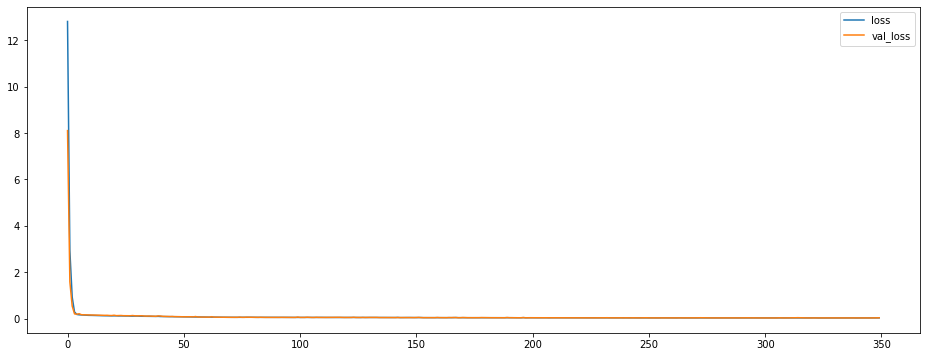

In [156]:
pd.DataFrame(model.history.history).plot(figsize = (16,6))

In [157]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             multiple                  150       
_________________________________________________________________
dense_13 (Dense)             multiple                  930       
_________________________________________________________________
dense_14 (Dense)             multiple                  620       
_________________________________________________________________
dense_15 (Dense)             multiple                  420       
_________________________________________________________________
dense_16 (Dense)             multiple                  210       
_________________________________________________________________
dense_17 (Dense)             multiple                  11        
Total params: 2,341
Trainable params: 2,341
Non-trainable params: 0
____________________________________________________

### Predictions
- Will use the model to predict vaues related to the XTest data 

In [158]:
predicitons = model.predict(X_test)

In [159]:
predicitons.shape

(1001, 1)

In [160]:
y_test.shape

(1001,)

### Metrics
 - Model shows that the our X values (capital Markets) explains 90% of the Aaa corporate bind Yield

In [161]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score

In [162]:
mean_absolute_error(y_test, predicitons)

0.14745570796353002

In [163]:
mean_squared_error(y_test, predicitons)

0.035765754538118186

In [164]:
explained_variance_score(y_test, predicitons)

0.9098369031743698

### Prediction of most recent Day

In [165]:
X.shape

(2501, 4)

In [166]:
recent_date = working_data[-1:].iloc[0].name

In [167]:
recen_date

Timestamp('2020-06-22 00:00:00')

In [168]:
todays_Data = working_data.loc[recen_date].drop("DAAA")

In [169]:
todays_Data = scalar.transform(todays_Data.values.reshape(1,4))

In [170]:
model.predict(todays_Data)

array([[2.4404619]], dtype=float32)

### Predicitons on Random Day
- Will select a random day from the the entire working data set

In [211]:
from random import randint
random_index = randint(1,len(working_data))
random_day = working_data.drop("DAAA", axis = 1).iloc[random_index]

In [212]:
random_day = scalar.transform(random_day.values.reshape(1,4))

In [213]:
random_day

array([[0.98201125, 0.97941974, 0.93974774, 0.94557619]])

In [214]:
model.predict(random_day)

array([[2.7108932]], dtype=float32)

### True Value
- Lets see with the true Value for the Aaa corporate bond if on the selected day

In [215]:
working_data.iloc[random_index]["DAAA"]

2.74